# InceptionV3 CNN Model for Stanford Dogs Dataset Classification
## Context
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.
## Content
* Number of categories: 120
* Number of images: 20,580
* Annotations: Class labels, Bounding boxes


# Installing and Importing Libraries

In [20]:
!pip install keract

In [21]:
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard

# Dataset

In [2]:
train_data_dir = "../input/stanford-dogs-dataset/images/Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64

In [3]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [4]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 42
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 42

)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [5]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

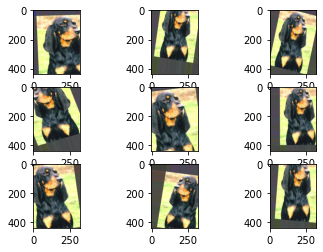

In [26]:
img = load_img('../input/stanford-dogs-dataset/images/Images/n02086910-papillon/n02086910_2188.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

# Model

In [7]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [8]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


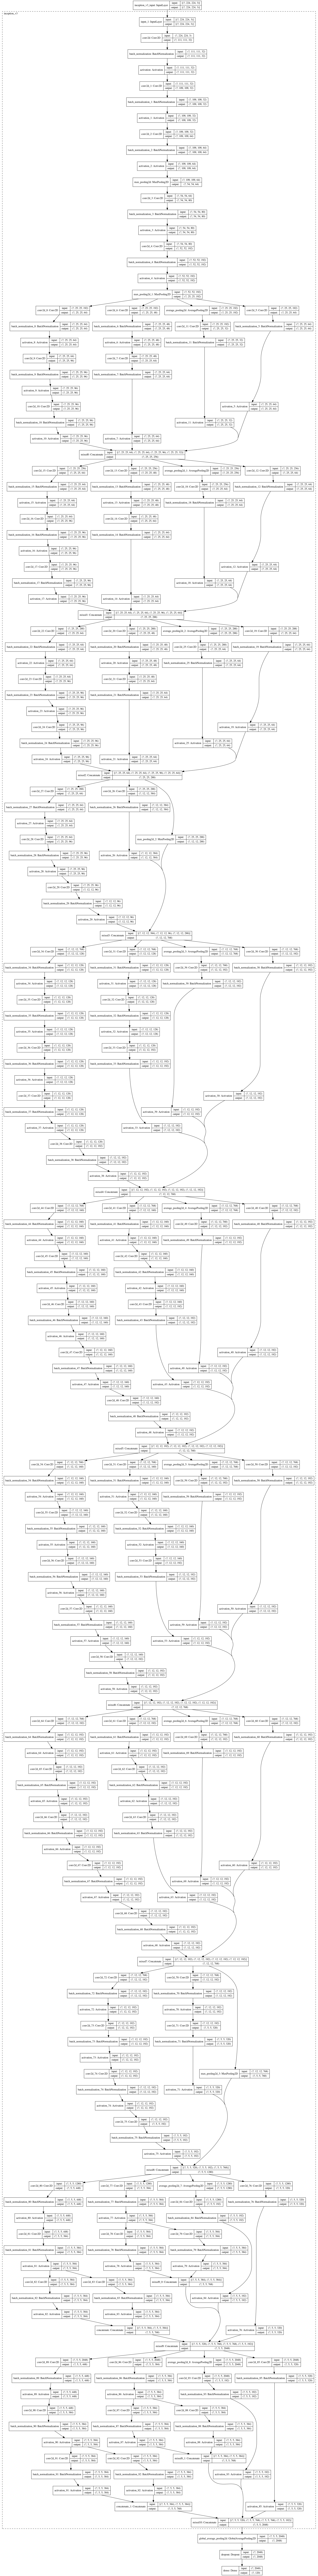

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Baseline Model Training

In [11]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [18]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

tensorboard = TensorBoard(
    log_dir = 'logs',
    histogram_freq=0,
    batch_size= batch_size,
    write_graph= True,
    write_grads= True,
    write_images= False,
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [12]:
history = model.fit(
    train_generator, 
    epochs= 15,
    steps_per_epoch = nb_train_samples//batch_size, 
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/15

Epoch 00001: val_loss improved from inf to 1.73853, saving model to baseline_model.h5
257/257 - 288s - loss: 3.4238 - accuracy: 0.2827 - val_loss: 1.7385 - val_accuracy: 0.6818
Epoch 2/15

Epoch 00002: val_loss improved from 1.73853 to 0.98369, saving model to baseline_model.h5
257/257 - 254s - loss: 1.6137 - accuracy: 0.6309 - val_loss: 0.9837 - val_accuracy: 0.7674
Epoch 3/15

Epoch 00003: val_loss improved from 0.98369 to 0.80563, saving model to baseline_model.h5
257/257 - 257s - loss: 1.1952 - accuracy: 0.6889 - val_loss: 0.8056 - val_accuracy: 0.7847
Epoch 4/15

Epoch 00004: val_loss improved from 0.80563 to 0.73302, saving model to baseline_model.h5
257/257 - 260s - loss: 1.0468 - accuracy: 0.7090 - val_loss: 0.7330 - val_accuracy: 0.7929
Epoch 5/15

Epoch 00005: val_loss improved from 0.73302 to 0.70390, saving model to baseline_model.h5
257/257 - 261s - loss: 0.9644 - accuracy: 0.7281 - val_loss: 0.7039 - val_accuracy: 0.7959
Epoch 6/15

Epoch 00006: val_loss impro

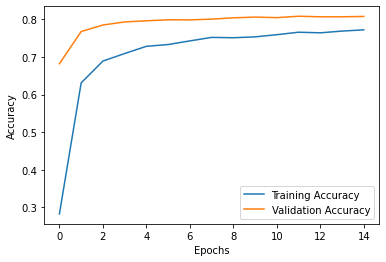

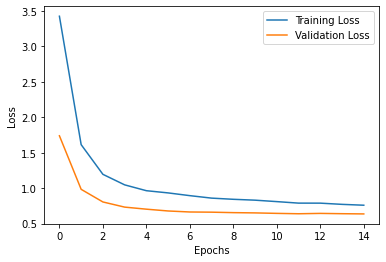

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch_v1.png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch_v1.png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

In [19]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 19s 302ms/step - loss: 0.6363 - accuracy: 0.8080
Validation Loss:  0.6363058090209961
Validation Accuracy:  0.8079567551612854
